In [76]:
import itertools
import matplotlib.pyplot as plt
from rl.distribution import Categorical
from rl.markov_process import (FiniteMarkovProcess, MarkovProcess,
                                MarkovRewardProcess, NonTerminal, State)


In [34]:
class SnakesAndLadders(FiniteMarkovProcess[int]):
    def __init__(self, p):
        irregulars = {1,4,9,16,21,28,36,47,49,51,56,62,64,71,80,87,93,95,98}
        change = {1:38, 4:14, 9:31, 16:6,
                21:42, 28:84, 36:44, 47:26, 
                49:11, 51:67, 56:53, 62:19,
                64:60, 71:91, 80:100, 87:24,
                93:73, 95:75, 98:78}
        regulars = set(range(0,101))
        regulars = regulars.difference(irregulars)
        transition_map = {
            b : Categorical({(b+x if b+x in regulars else change[b+x]): (1/p)
                for x in range(1,p)}
            ) for b in range(0,99)
        }
        super().__init__(transition_map)

In [79]:
simulation = SnakesAndLadders(6)
startstate = simulation.transition(NonTerminal(0))
tracer = simulation.traces(startstate)
runcounter = itertools.islice(tracer, 10000)
rundata = []
for run in runcounter:
    count = sum(1 for i in run)
    rundata.append(count)



(array([6.310e+03, 2.598e+03, 7.720e+02, 2.330e+02, 6.600e+01, 1.500e+01,
        6.000e+00]),
 array([  7.        ,  44.28571429,  81.57142857, 118.85714286,
        156.14285714, 193.42857143, 230.71428571, 268.        ]),
 <BarContainer object of 7 artists>)

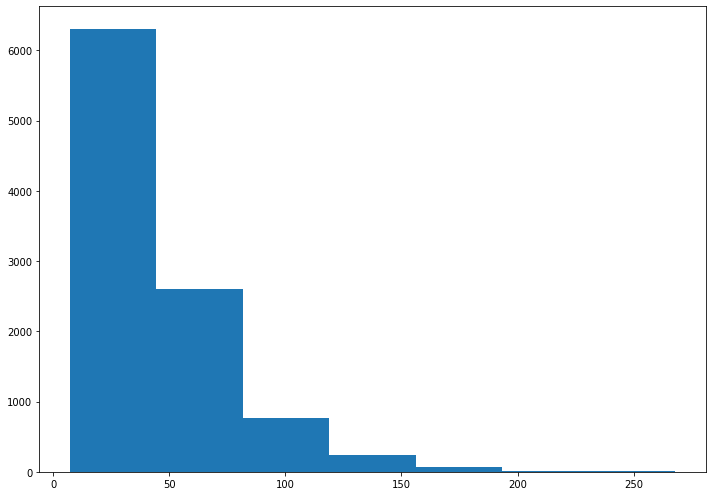

In [84]:
fig, ax = plt.subplots(1,1, figsize = (10,7), tight_layout = True)
ax.hist(rundata, bins = 7)